# 互评作业4：离群点分析与异常检测

姓名：臧梓硕

学号：3120191072

学院：计算机学院

GitHub:https://github.com/zzsynl126/Datamining_homework4

## 实验目标： 

从Anomaly Detection Meta-Analysis Benchmarks提供的benchmark数据集中任选两个数据集，借助PyOD工具找出异常点，并分析各算法的性能。

这里对Anomaly Detection Meta-Analysis Benchmarks提供的benchmark数据集进行说明：数据集中共分为两大部分数据，分别为meta_data文件夹中的原始整体数据以及benchmarks文件夹中进行划分后的多个子数据集，子数据集之间相互独立。

## 实验步骤

**1、在原始整体数据集上利用多种算法找到全局的离群点并评测各算法的性能。**

**2、在划分后的所有benchmark子数据集中分别用多种算法分别找到每个子文件的离群点并且评测各算法性能。**

In [1]:
import pandas as pd
import numpy as np
from pyod.models.cblof import CBLOF
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
import os
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
import random
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

C:\Users\dell\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


## 1. 选用数据集1：skin_benchmarks

该数据集中标注后的原始数据skin.preproc.csv中包括的9个数据列，分别为point.id、motherset、origin、original.label、diff.score、ground.truth、R、G、B，其中重要的是ground.truth、R、G、B，ground.truth为标注好的正确标签，R、G、B为数据属性特征值，用来进行预测。

划分后的子数据集共包括1500个.csv数据文件（注：文件的最大标号为1740，但实际只包括了1500个文件），每个子数据文件的主要数据列和原始数据相同。
1.1 整体数据集异常检测和算法评测

### 1.1 未划分原数据集检测

#### 数据处理并展示

In [2]:
#读取数据并做数据展示
df = pd.read_csv("data/data/skin/meta_data/skin.preproc.csv")
print("数据数量：%d" %len(df))
df.head()

数据数量：245057


,point.id,motherset,origin,original.label,ground.truth,R,G,B
0,skin_point_000001,skin,binary,1,anomaly,-0.820254,-0.792566,-0.002441
1,skin_point_000002,skin,binary,1,anomaly,-0.836317,-0.809249,-0.016223
2,skin_point_000003,skin,binary,1,anomaly,-0.852380,-0.825932,-0.030004
3,skin_point_000004,skin,binary,1,anomaly,-0.884505,-0.859298,-0.057567
4,skin_point_000005,skin,binary,1,anomaly,-0.884505,-0.859298,-0.057567


下面我们生成用于训练模型的特征值和标签值。特征值用X表示，标签值用Y表示。

In [3]:
#形成训练数据和标签，并将形成0-1标签为实际标签
X1 = df['R'].values.reshape(-1,1)
X2 = df['G'].values.reshape(-1,1)
X3= df['B'].values.reshape(-1,1)
X = np.concatenate((X1,X2,X3),axis=1)
label=[]
count=0
for i in range(len(df)):
    if df['ground.truth'][i]=="nominal":
        label+=[1]
    if df['ground.truth'][i]=='anomaly':
        label+=[0]
        count+=1
Y=label


In [4]:
#可视化函数
def draw_plt(p11,p12,p13,p21,p22,p23):
    ax = plt.subplot(111, projection='3d') 
    ax.scatter(p11, p12, p13, c='r') # 绘制数据点
    ax.scatter(p21, p22, p23, c='g') # 绘制数据点
    ax.set_zlabel('Z') # 坐标轴
    ax.set_ylabel('Y')
    ax.set_xlabel('X')
    plt.show()

### 原数据集离群点和正常值的可视化

下面我们将原始数据中离群点和正常点用三维散点图画出，进行原始数据的展示。其中红色表示离群点，绿色表示正常点。

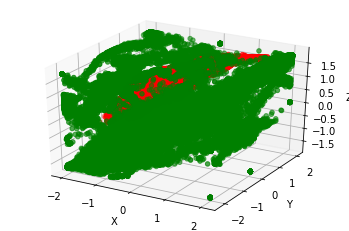

In [5]:
RX1 =  df['R'][df['ground.truth']=='anomaly'].values.reshape(-1,1)
RX2=df['G'][df['ground.truth']=='anomaly'].values.reshape(-1,1)
RX3=df['B'][df['ground.truth']=='anomaly'].values.reshape(-1,1)
SX1 =  df['R'][df['ground.truth']=='nominal'].values.reshape(-1,1)
SX2=df['G'][df['ground.truth']=='nominal'].values.reshape(-1,1)
SX3=df['B'][df['ground.truth']=='nominal'].values.reshape(-1,1)
draw_plt(RX1,RX2,RX3,SX1,SX2,SX3)

### 全局离群点异常检测及算法评测

在这里采用多种算法进行异常检测并对各算法进行评测。使用的算法及简单介绍如下：

实验中利用PyOD工具分别使用基于邻近性的CBLOF、KNN、HBOS及基于聚类的IForest、FeatureBagging异常检测算法。

1、**CBLOF算法**

    CBLOF算法是基于聚类和邻近性的异常检测方法，它将数据分为香型集群和大型集群，然后根据点所属的簇的大小以及到最近的大簇的距离来计算异常分数。

2、**KNN算法**

    KNN算法是典型的基于邻近性的异常检测算法，对于任何数据点，到第k个最近邻居的距离可以被视为远离分数，PyOD支持三个KNN探测器，分别为最大KNN、均值KNN以及中位数KNN，区别在于作为离群值得分的距离的计算方法。在这里我们用默认的最大KNN算法，也就是使用最大距离作为离群值。

3、**HBOS算法**
    
     它比多变量方法快得多，但代价是精度较低

4、**Isolation Forest算法**
    
    该方法是基于聚类的方法，使用一组树完成数据分区。隔离森林提供了一个异常分数用来查看结构中点的隔离程度。

5、**Feature Bagging**

    功能装袋检测器在数据集的各种子样本上安装了许多基本检测器。 它使用平均或其他组合方法来提高预测精度。默认情况下，LOF用作基本估算器。 特征装袋首先通过随机选择特征子集来构造n个子样本。 这带来了基本估计的多样性。 最后，通过平均或取所有基本检测器的最大值来生成预测分数

注：在后续所有数据集上的异常检测都将采用这五种算法，因此在后续的报告中不再对算法进行介绍。

下面我们就利用上述的五种算法进行异常检测，延用原论文中的AUC和AP两个评测指标对算法性能进行评测，同时将预测结果可视化，使效果更直观。

在这里我们介绍一下AUC和AP评测指标：

    **AUC指标**：AUC指标是模型评测常用的指标之一，直观含义是任意取一个正样本和负样本，正样本得分大于负样本的概率。
    **AP指标** ：AP指标是每一类别precision的平均值。在这里我们可以看做是P-R曲线下的面积。

算法运行中：
算法：CBLOF 正在运行


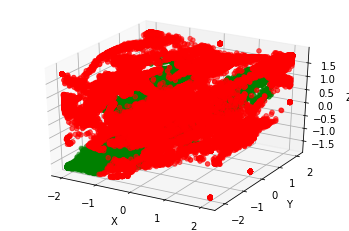

原数据的异常值数量为：50859；异常点比例为：0.207539；预测异常值数量：50853；预测正常值：194204；预测离群点数量比例：0.999882；AUC=0.618066；AP=0.833698
算法：CBLOF 运行完毕
算法：KNN 正在运行


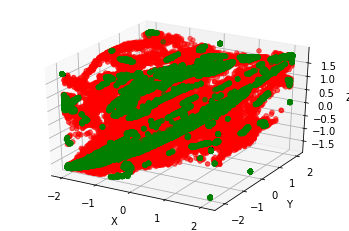

原数据的异常值数量为：50859；异常点比例为：0.207539；预测异常值数量：50741；预测正常值：194316；预测离群点数量比例：0.997680；AUC=0.558409；AP=0.812261
算法：KNN 运行完毕
算法：HBOS 正在运行


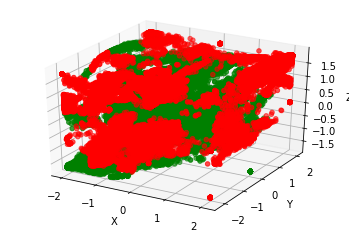

原数据的异常值数量为：50859；异常点比例为：0.207539；预测异常值数量：50634；预测正常值：194423；预测离群点数量比例：0.995576；AUC=0.474797；AP=0.784280
算法：HBOS 运行完毕
算法：Isolation Forest 正在运行


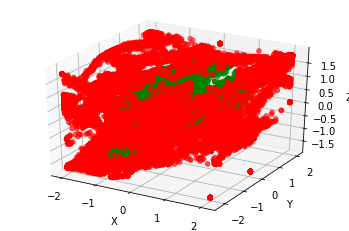

原数据的异常值数量为：50859；异常点比例为：0.207539；预测异常值数量：50858；预测正常值：194199；预测离群点数量比例：0.999980；AUC=0.423766；AP=0.768386
算法：Isolation Forest 运行完毕
算法：Feature Bagging 正在运行


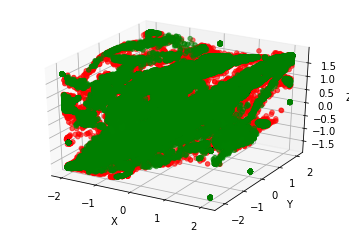

原数据的异常值数量为：50859；异常点比例为：0.207539；预测异常值数量：50859；预测正常值：194198；预测离群点数量比例：1.000000；AUC=0.542164；AP=0.806636
算法：Feature Bagging 运行完毕


In [6]:
random_state = np.random.RandomState(42)
outliers_fraction = count/len(df)
classifiers = {
    'CBLOF':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
    'KNN': KNN(contamination=outliers_fraction),
    'HBOS': HBOS(contamination=outliers_fraction),
    'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
    'Feature Bagging':FeatureBagging(LOF(n_neighbors=35),contamination=outliers_fraction,check_estimator=False,random_state=random_state),
}
print("算法运行中：")
for i, (clf_name, clf) in enumerate(classifiers.items()):
    print("算法：%s 正在运行" % (clf_name))
    clf.fit(X)
    y_pred=clf.labels_ 
    n_out=np.count_nonzero(y_pred)
    n_normal=len(y_pred)-n_out

    dfx = df
    dfx['outlier'] = y_pred.tolist()
    OX1 =  dfx['R'][dfx['outlier'] == 1].values.reshape(-1,1)
    OX2 =  dfx['G'][dfx['outlier'] == 1].values.reshape(-1,1)
    OX3 =  dfx['B'][dfx['outlier'] == 1].values.reshape(-1,1)
    IX1 =  dfx['R'][dfx['outlier'] == 0].values.reshape(-1,1)
    IX2 =  dfx['G'][dfx['outlier'] == 0].values.reshape(-1,1)
    IX3 =  dfx['B'][dfx['outlier'] == 0].values.reshape(-1,1)
    draw_plt(OX1,OX2,OX3,IX1,IX2,IX3)
    for i in range(len(y_pred)):
        if(y_pred[i]==1):
            y_pred[i]=0
        else:
            y_pred[i]=1
    AUC=roc_auc_score(Y, y_pred)
    AP=average_precision_score(Y, y_pred)
    print("原数据的异常值数量为：%d；异常点比例为：%4lf；预测异常值数量：%d；预测正常值：%d；预测离群点数量比例：%4lf；AUC=%4lf；AP=%4lf" %(count,outliers_fraction,n_out,n_normal,n_out/count,AUC,AP))
    print("算法：%s 运行完毕" % (clf_name))

从上面的评测指标和可视化结果看。Feature Bagging算法在该数据集上的性能较好。

### 1.2 划分后的所有benchmark子数据集检测

下面我们在划分后的所有benchmark子数据集上分别进行异常值的检测。由于工作量较大，所以代码的编写和运行在VScode中进行，完整代码地址为：https://github.com/zzsynl126/Datamining_homework4/blob/master/skin_process.py
由于数据处理过程大致相似，这里就不再展示具体代码，采用伪代码的方式展示思路。

In [ ]:
创建对应于每个算法的结果存放文件
for i in all_benchmark_dir: ##
    read data in all_benchmark_dir[i]
    create X,Y
    for i in algorithms:
        算法执行
        计算检测得到离群点值，AUC，AP等
        保存结果到对应文件
END

下面展示运行以及保存文件的部分截图。其中每个结果文件的每一列代表在一个.csv文件上的运行结果，各数据列含义分别为算法名称、原数据离群点占比、原数据离群点数量、预测离群点数量、预测正常值数量、AUC、AP，结果文件夹访问地址为：https://github.com/zzsynl126/Datamining_homework4/blob/master/results/results_skin

**运行截图**

![](https://pics.images.ac.cn/image/5efbebee08ff4.html)

**结果文件**

![](https://pics.images.ac.cn/image/5efbebea4e6d7.html)

![](https://pics.images.ac.cn/image/5efbebed92b04.html)

### 结果分析

    注：因为存在部分子数据离群点的占比超出了50%，对于这部分数据处理时降低算法需要的离群点的比例到0.4，对于这部分计算得到的结果意义不大，所以在分析时去除这些数据。

1、离群点比例分析

在保存的结果中计算检测到的离群点个数和实际离群点个数的比值的整体平均值，结果如下：

CBLOF算法的均值为0.95；Feature Bagging算法的均值为0.98；HBOS算法的均值为0.78；Isolation 
Forest算法的均值为0.96；KNN算法的均值为0.98

从离群点识别个数来看HBOS识别的个数较其他算法少，其他算法相差不大。

2、AUC和AP分析

下面对每个算法在所有benchmarks文件中得到的运行结果中的AUC值和AP值进行五数概括

In [7]:
path_r = 'data/data/skin/results_skin/'

files = os.listdir(path_r)

train_csv = list(files)

file_auc=[]
file_ap=[]
for i in range(len(train_csv)):
    file_r=pd.read_csv(path_r+train_csv[i],usecols=['out_rate','AUC','AP'])
    file_s=file_r[file_r['out_rate']<0.5]['AUC']
    file_p=file_r[file_r['out_rate']<0.5]['AP']
    file_auc.append(file_s)
    file_ap.append(file_p)
for i in range(len(file_ap)):
    print(train_csv[i]+"中\nAUC的五数概括为：")
    print(file_auc[i].describe())
    print("\nAP的五数概括为")
    print(file_ap[i].describe())
    print("\n")

CBLOF_re.csv中
AUC的五数概括为：
count    1440.000000
mean        0.504263
std         0.060658
min         0.366481
25%         0.477193
50%         0.497487
75%         0.499750
max         0.743860
Name: AUC, dtype: float64

AP的五数概括为
count    1440.000000
mean        0.938343
std         0.075715
min         0.739297
25%         0.895319
50%         0.981831
75%         0.994975
max         0.999000
Name: AP, dtype: float64


Feature Bagging_re.csv中
AUC的五数概括为：
count    1440.000000
mean        0.491940
std         0.017959
min         0.416421
25%         0.485965
50%         0.497487
75%         0.499499
max         0.553872
Name: AUC, dtype: float64

AP的五数概括为
count    1440.000000
mean        0.935775
std         0.076955
min         0.762360
25%         0.898017
50%         0.972380
75%         0.994975
max         0.999000
Name: AP, dtype: float64


HBOS_re.csv中
AUC的五数概括为：
count    1440.000000
mean        0.487831
std         0.032441
min         0.374518
25%         0.479644
50%         0

总结如下：

（1）CBLOF算法结果中：
AUC最大值为0.74，最小值为0.37，平均值为0.5；AP最小值为0.74；

（2）Fearture Bagging算法结果中：
AUC最大值为0.55，最小值为0.42，平均值为0.49；AP最小值为0.76；

（3）HBOS算法结果中：
AUC最大值为0.78，最小值为0.37，平均值为0.49；AP最小值为0.74；

（4）Isolation Forest算法结果中：
AUC最大值为0.72，最小值为0.37，平均值为0.48；AP最小值为0.74；

（5）KNN算法结果中：
AUC最大值为0.5，最小值为0.37，平均值为0.48；AP最小值为0.74。

下面画出AUC和AP结果的盒图，方便数据的直观分析

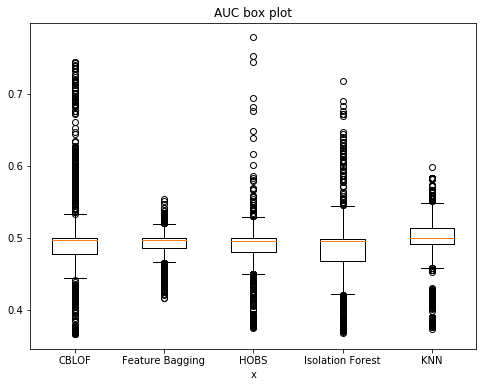

In [8]:
path_r = 'data/data/skin/results_skin/'

files = os.listdir(path_r)

train_csv = list(files)

file_auc=[]
file_ap=[]
for i in range(len(train_csv)):
    file_r=pd.read_csv(path_r+train_csv[i],usecols=['out_rate','AUC','AP'])
    file_s=np.array(file_r[file_r['out_rate']<0.5]['AUC']).tolist()
    file_p=np.array(file_r[file_r['out_rate']<0.5]['AP']).tolist()
    file_auc.append(file_s)
    file_ap.append(file_p)
fig=plt.figure(figsize=(8,6))
plt.boxplot(file_auc,notch=False, sym='o', vert=True)
plt.xticks([x+1 for x in range(len(file_auc))], ['CBLOF', 'Feature Bagging', 'HOBS', 'Isolation Forest','KNN'])
plt.title('AUC box plot')
plt.xlabel('x')
plt.show()

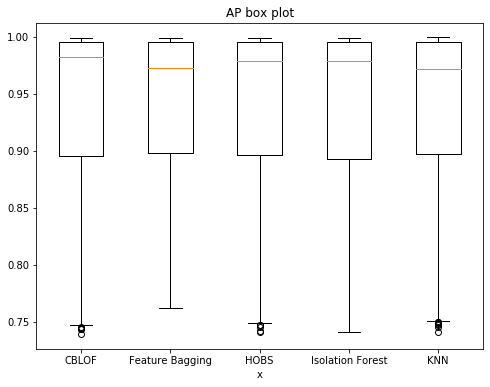

In [9]:
fig=plt.figure(figsize=(8,6))
plt.boxplot(file_ap,notch=False, sym='o', vert=True)
plt.xticks([x+1 for x in range(len(file_ap))], ['CBLOF', 'Feature Bagging', 'HOBS', 'Isolation Forest','KNN'])
plt.title('AP box plot')
plt.xlabel('x')
plt.show()

从上面的结果展示可以看出，实验得到的结果和论文中的结果大致相似。

从AUC值看，Fearture Bagging算法性能较为稳定，它的性能受到离群点所占比例的影响是比较小的，但整体效果不太好，通过分析取得较高AUC值的数据，我们发现性能较好的模型离群值比例大致在0.05到0.1范围内，所以要建立更为鲁棒的模型，离群值比例可以控制在这个范围内。

接下来对AP值进行分析，各算法的AP值大致相似，最小值为0.7以上，可以看到模型的效果还是比较好的，同样离群点所占比例较低时，AP值也会增加，这主要是因为离群点较少的话，不管离群点是否预测正确，准确率都相对较高。

## 2. 选用数据集1：wine_benchmarks

该数据集中标注后的原始数据wine.preproc.csv中包括的17个数据列，选择其中的12个对分析有意义的数据列，分别为:
'ground.truth','fixed.acidity','volatile.acidity','citric.acid','residual.sugar','chlorides','free.sulfur.dioxide','total.sulfur.dioxide','density','pH','sulphates','alcohol'，其中ground.truth为标注好的标签。

划分后的子数据集共包括1210个.csv数据文件（注：文件的最大标号为1680，但实际只包括了1210个文件），每个子数据文件的主要数据列和原始数据相同。

### 2.1 未划分原数据集检测

#### 数据处理并展示

In [10]:
#读取数据并做数据展示
df = pd.read_csv("data/data/wine/meta_data/wine.preproc.csv")
print("数据数量：%d" %len(df))
df.head()

数据数量：6497


,point.id,motherset,origin,original.label,ground.truth,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol
0,wine_point_0001,wine,regression,6,nominal,-0.166076,-0.423150,0.284664,3.206682,-0.314951,0.815503,0.959902,2.102052,-1.358944,-0.546136,-1.418449
1,wine_point_0002,wine,regression,6,nominal,-0.706019,-0.240931,0.147035,-0.807775,-0.200775,-0.931035,0.287595,-0.232314,0.506876,-0.277330,-0.831551
2,wine_point_0003,wine,regression,6,nominal,0.682405,-0.362411,0.559923,0.306184,-0.172231,-0.029596,-0.331634,0.134515,0.258100,-0.613338,-0.328496
3,wine_point_0004,wine,regression,6,nominal,-0.011807,-0.666110,0.009405,0.642474,0.056121,0.928182,1.242978,0.301255,-0.177258,-0.882144,-0.496181
4,wine_point_0005,wine,regression,6,nominal,-0.011807,-0.666110,0.009405,0.642474,0.056121,0.928182,1.242978,0.301255,-0.177258,-0.882144,-0.496181


下面我们生成用于训练模型的特征值和标签值。特征值用X表示，标签值用Y表示。

In [11]:

label=[]
X=df[['fixed.acidity','volatile.acidity','citric.acid','residual.sugar','chlorides','free.sulfur.dioxide','total.sulfur.dioxide','density','pH','sulphates','alcohol']]
count=0
for i in range(len(df)):
    if df['ground.truth'][i]=="nominal":
        label+=[1]
    if df['ground.truth'][i]=='anomaly':
        label+=[0]
        count+=1
Y=label

### 全局离群点异常检测及算法评测

下面我们就利用第一节的五种算法进行异常检测，延用原论文中的AUC和AP两个评测指标对算法性能进行评测，同时将预测结果可视化，使效果更直观。

In [12]:
random_state = np.random.RandomState(42)
outliers_fraction = count/len(df)
classifiers = {
    'CBLOF':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
    'KNN': KNN(contamination=outliers_fraction),
    'HBOS': HBOS(contamination=outliers_fraction),
    'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
    'Feature Bagging':FeatureBagging(LOF(n_neighbors=35),contamination=outliers_fraction,check_estimator=False,random_state=random_state),
}
print("算法运行中：")
for i, (clf_name, clf) in enumerate(classifiers.items()):
    print("算法：%s 正在运行" % (clf_name))
    clf.fit(X)
    y_pred=clf.labels_ 
    n_out=np.count_nonzero(y_pred)
    n_normal=len(y_pred)-n_out
    for i in range(len(y_pred)):
        if(y_pred[i]==1):
            y_pred[i]=0
        else:
            y_pred[i]=1
    
    AUC=roc_auc_score(Y, y_pred)
    AP=average_precision_score(Y, y_pred)
    print("原数据的异常值数量为：%d；异常点比例为：%4lf；预测异常值数量：%d；预测正常值：%d；预测离群点数量比例：%4lf；AUC=%4lf；AP=%4lf" %(count,outliers_fraction,n_out,n_normal,n_out/count,AUC,AP))
    print("算法：%s 运行完毕" % (clf_name))

算法运行中：
算法：CBLOF 正在运行
原数据的异常值数量为：2384；异常点比例为：0.366939；预测异常值数量：2383；预测正常值：4114；预测离群点数量比例：0.999581；AUC=0.554195；AP=0.659821
算法：CBLOF 运行完毕
算法：KNN 正在运行
原数据的异常值数量为：2384；异常点比例为：0.366939；预测异常值数量：2383；预测正常值：4114；预测离群点数量比例：0.999581；AUC=0.530342；AP=0.647654
算法：KNN 运行完毕
算法：HBOS 正在运行
原数据的异常值数量为：2384；异常点比例为：0.366939；预测异常值数量：2384；预测正常值：4113；预测离群点数量比例：1.000000；AUC=0.544466；AP=0.654785
算法：HBOS 运行完毕
算法：Isolation Forest 正在运行
原数据的异常值数量为：2384；异常点比例为：0.366939；预测异常值数量：2384；预测正常值：4113；预测离群点数量比例：1.000000；AUC=0.536515；AP=0.650744
算法：Isolation Forest 运行完毕
算法：Feature Bagging 正在运行
原数据的异常值数量为：2384；异常点比例为：0.366939；预测异常值数量：2384；预测正常值：4113；预测离群点数量比例：1.000000；AUC=0.538834；AP=0.651916
算法：Feature Bagging 运行完毕


从结果可以看出CBLOF得分相对其他算法高一些，说明性能较其他算法好一些，但从差别不是很大。

### 2.2 划分后的所有benchmark子数据集检测

下面我们在划分后的所有benchmark子数据集上分别进行异常值的检测。由于工作量较大，所以代码的编写和运行在VScode中进行，完整代码地址为：https://github.com/zzsynl126/Datamining_homework4/blob/master/wine_process.py
由于数据处理过程大致相似，这里就不再展示具体代码，处理思路和第一个数据集的处理思想相同。

下面展示运行以及保存文件的部分截图。其中每个结果文件的每一列代表在一个.csv文件上的运行结果，各数据列含义分别为算法名称、原数据离群点占比、原数据离群点数量、预测离群点数量、预测正常值数量、AUC、AP，结果文件夹访问地址为：https://github.com/zzsynl126/Datamining_homework4/blob/master/results/results_wine

**运行截图**

![](https://pics.images.ac.cn/image/5efbebebc4fa8.html)

**结果文件**

![](https://pics.images.ac.cn/image/5efbebea9fe74.html)

![](https://pics.images.ac.cn/image/5efbebed3993c.html)

### 结果分析

    注：和上一节一样，因为存在部分子数据离群点的占比超出了50%，对于这部分数据处理时降低算法需要的离群点的比例到0.3，对于这部分计算得到的AUC和AP的意义不大，所以在分析时去除这些数据。

1、离群点比例分析

在保存的结果中计算检测到的离群点个数和实际离群点个数的比值的整体平均值，结果如下：
CBLOF算法的均值为1；Feature Bagging算法的均值为0.98；HBOS算法的均值为0.99；Isolation Forest算法的均值为0.99；KNN算法的均值为1；
各算法找到的离群点数量占比平均值都很相近，相差不大。

2、AUC和AP分析

下面对每个算法在所有benchmarks文件中得到的运行结果中的AUC值和AP值进行五数概括

In [13]:
path_r = 'data/data/wine/results/results_wine/'

files = os.listdir(path_r)

train_csv = list(files)

file_auc=[]
file_ap=[]
for i in range(len(train_csv)):
    file_r=pd.read_csv(path_r+train_csv[i],usecols=['out_rate','AUC','AP'])
    file_s=file_r[file_r['out_rate']<0.5]['AUC']
    file_p=file_r[file_r['out_rate']<0.5]['AP']
    file_auc.append(file_s)
    file_ap.append(file_p)
for i in range(len(file_ap)):
    print(train_csv[i]+"中\nAUC的五数概括为：")
    print(file_auc[i].describe())
    print("\nAP的五数概括为")
    print(file_ap[i].describe())
    print("\n")

CBLOF_re.csv中
AUC的五数概括为：
count    1161.000000
mean        0.517892
std         0.033365
min         0.482470
25%         0.497949
50%         0.508745
75%         0.527958
max         0.967105
Name: AUC, dtype: float64

AP的五数概括为
count    1161.000000
mean        0.893371
std         0.147986
min         0.493244
25%         0.902251
50%         0.952069
75%         0.994868
max         0.999459
Name: AP, dtype: float64


Feature Bagging_re.csv中
AUC的五数概括为：
count    1161.000000
mean        0.519730
std         0.026711
min         0.478159
25%         0.499460
50%         0.519677
75%         0.532524
max         0.870066
Name: AUC, dtype: float64

AP的五数概括为
count    1161.000000
mean        0.893218
std         0.148812
min         0.492090
25%         0.903672
50%         0.953618
75%         0.994866
max         0.999460
Name: AP, dtype: float64


HBOS_re.csv中
AUC的五数概括为：
count    1161.000000
mean        0.513209
std         0.023020
min         0.468382
25%         0.497448
50%         0

总结如下：

CBLOF算法结果中：
AUC最大值为0.97，最小值为0.48，平均值为0.52，AP最小值0.49；

Feature Bagging算法结果中：
AUC最大值为0.87，最小值为0.48，平均值为0.52，AP在0.49到1之间；

HBOS算法结果中：
AUC最大值为0.7，最小值为0.47，平均值为0.51，AP在0.49到1之间；

Isolation Forest算法结果中：
AUC最大值为0.77，最小值为0.47，平均值为0.52，AP在0.49到1之间；

KNN算法结果中：
AUC最大值为0.75，最小值为0.48，平均值为0.52，AP在0.5到1之间。



下面画出AUC和AP结果的盒图，方便数据的直观分析

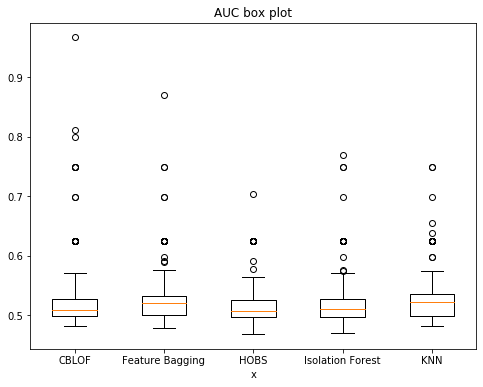

In [14]:
path_r = 'data/data/wine/results/results_wine/'

files = os.listdir(path_r)

train_csv = list(files)

file_auc=[]
file_ap=[]
for i in range(len(train_csv)):
    file_r=pd.read_csv(path_r+train_csv[i],usecols=['out_rate','AUC','AP'])
    file_s=np.array(file_r[file_r['out_rate']<0.5]['AUC']).tolist()
    file_p=np.array(file_r[file_r['out_rate']<0.5]['AP']).tolist()
    file_auc.append(file_s)
    file_ap.append(file_p)
fig=plt.figure(figsize=(8,6))
plt.boxplot(file_auc,notch=False, sym='o', vert=True)
plt.xticks([x+1 for x in range(len(file_auc))], ['CBLOF', 'Feature Bagging', 'HOBS', 'Isolation Forest','KNN'])
plt.title('AUC box plot')
plt.xlabel('x')
plt.show()

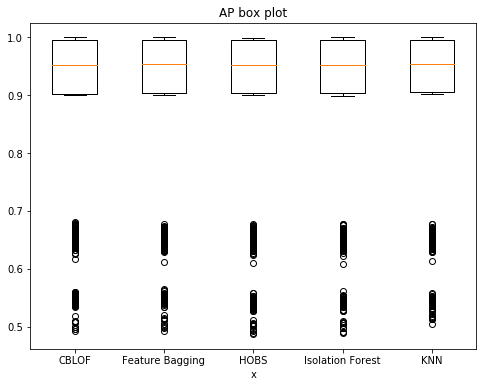

In [15]:
fig=plt.figure(figsize=(8,6))
plt.boxplot(file_ap,notch=False, sym='o', vert=True)
plt.xticks([x+1 for x in range(len(file_ap))], ['CBLOF', 'Feature Bagging', 'HOBS', 'Isolation Forest','KNN'])
plt.title('AP box plot')
plt.xlabel('x')
plt.show()

从上面的结果我们可以看到结果中AP的波动较大，且存在断层。分析原结果数据发现，AP值较高对应的离散值比例均比较低，均为0.1左右或小于0.1；AP值较小的时候对应的离散值比例较高，这和数据一结果得到的结论一样，也就是AP随着离散值所占比例的降低是会增加的。

对AUC结果分析时，各算法性能相差不大，整体上看Fearture Bagging和KNN相对好一些。

同时我们注意到CBLOF和Fearture Bagging算法中AUC的最大值较其他算法都高，通过查询原始结果数据可以发现AUC最大时对应的离散值比例均为0.05，通过横向比较其他的算法在该比例时的AUC和AP值，发现其他算法同样是在该比例取得的ACU最大值。除此之外还发现ACU较高值和数据一的处理结果相同，多集中与0.05到0.1之间，因此在建立鲁棒模型的时候可以考虑将离群值比例设在该区间内。

## 3. 总结

通过上面的分析，我们可以看到离群点所占比例对算法的性能还是有影响的，我觉得这是由于异常数据占比较多的情况下，模型训练拟合检测离群点时就越困难。从数据集的结果分析看，如果要建立更鲁棒的模型，可以将离散点比例设在0.05至0.1之间，但是当我们的目的是尽可能多的识别的时候可能需要做出相应的调整，就像在这次实验中目的是想将离群点全部检测出来，所以在算法参数中使用了实际数据集中的离群点占比。